In [1]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

device = "cuda:1"
model_id = "gpt2-large"
model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import torch

nltk.download('punkt')
nltk.download('stopwords')
STOP_WORDS = set(stopwords.words('english'))

# Assuming 'matches', 'dialog', 'offset', and 'perpl' are defined earlier in your code
def perplexity_to_info(dialog, tokens, perpl, answers, pattern = '<(SPK[1-9]|MOD)>'):

    matches = re.findall(pattern, "".join(dialog))
    unique_matches = np.unique(matches)
    #encodings = tokenizer(" ".join(dialog), return_tensors="pt")
    encodings = torch.cat(tokens)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)
    
    ppl_to_info = []
    prev_idx_pp = 0
    for idx, (match,answer) in enumerate(zip(matches,answers)):
        idx_pp = tokens_ids_per_sentence[idx]
        patt = matches[idx]
        label = re.sub(r'\[([^\]]+)\]: ', '', dialog[idx])
        tokens = encodings[prev_idx_pp:idx_pp]
        decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
        perpl_per_sent = perpl[prev_idx_pp:idx_pp]
        mean_value=np.nanmean(np.asarray(perpl_per_sent))
        prev_idx_pp=idx_pp
        ppl_to_info.append({"label":answer, "perpl": np.asarray(perpl_per_sent)})
    
    return ppl_to_info

def filter_out_common_words(words, perpl):
    # Remove stop words and corresponding perplexity values
    filtered_words = [word for word in words if word.lower().strip() not in STOP_WORDS]
    filtered_word_indices = [i for i, word in enumerate(words) if word.lower().strip() not in STOP_WORDS]
    assert len(list(np.asarray(perpl)[filtered_word_indices])) == len(filtered_words)
    return list(np.asarray(perpl)[filtered_word_indices]), filtered_word_indices

def perplexity_to_info_filtering_out_common_words(dialog, tokens, perpl, answers, matches, pattern = '<(SPK[1-9]|MOD)>'):
    
    encodings = torch.cat(tokens)
    unique_matches = np.unique(matches)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)
    
    
    ppl_to_info = []
    prev_idx_pp = 0
    dialog_filtered = []
    for idx, (match,answer) in enumerate(zip(matches,answers)):
        idx_pp = tokens_ids_per_sentence[idx]
        patt = matches[idx]
        label = re.sub(pattern, '', dialog[idx])
        tokens = encodings[prev_idx_pp:idx_pp]
        decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
        assert len(decoded) == len(perpl[prev_idx_pp:idx_pp])
        perpl_per_sent, filtered_word_indices = filter_out_common_words(decoded, perpl[prev_idx_pp:idx_pp])
        assert len(perpl_per_sent) == len(tokens[filtered_word_indices])
        dialog_filtered.append(tokens[filtered_word_indices])
        mean_value=np.nanmean(np.asarray(perpl_per_sent))
        prev_idx_pp=idx_pp
        ppl_to_info.append({"label":answer, "perpl": np.asarray(perpl_per_sent)})
        
    return dialog_filtered, ppl_to_info

def compute_per_user_mean_perplexity_filtering_out_common_words(dialog, tokens, perpl, matches, pattern = '<(SPK[1-9]|MOD)>'):

    encodings = torch.cat(tokens)
    unique_matches = np.unique(matches)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)
    
    prev_idx_pp = 0
    user_to_ppl = {}
    decoded_utterances = []
    for idx, match in enumerate(matches):
        idx_pp = tokens_ids_per_sentence[idx]
        patt = matches[idx]
        label = re.sub(pattern, '', dialog[idx])
        tokens = encodings[prev_idx_pp:idx_pp]
        decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
        assert len(decoded) == len(perpl[prev_idx_pp:idx_pp])
        perpl_per_sent, filtered_word_indices = filter_out_common_words(decoded, perpl[prev_idx_pp:idx_pp])
        decoded_utterances.append([tokenizer.decode([token], skip_special_tokens=True) for token in tokens[filtered_word_indices]])
        assert len(perpl_per_sent) == len(tokens[filtered_word_indices])
        mean_value=np.nanmean(np.asarray(perpl_per_sent))
        prev_idx_pp=idx_pp
        if patt not in user_to_ppl:
            user_to_ppl[patt] = []
        user_to_ppl[patt].append(mean_value)
        
    return user_to_ppl, decoded_utterances

def compute_per_user_mean_perplexity(dialog, tokens, perpl, matches, pattern = '<(SPK[1-9]|MOD)>'):
    
    encodings = torch.cat(tokens)
    #matches = re.findall(pattern, "".join(dialog))
    unique_matches = np.unique(matches)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)


    prev_idx_pp = 0
    user_to_ppl = {}
    for idx in range(len(matches)):
        idx_pp = tokens_ids_per_sentence[idx]
        patt = matches[idx]
        tokens = encodings[prev_idx_pp:idx_pp]
        decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
        perpl_per_sent = perpl[prev_idx_pp:idx_pp]
        mean_value=np.nanmean(np.asarray(perpl_per_sent))
        if patt not in user_to_ppl:
            user_to_ppl[patt] = []
        user_to_ppl[patt].append(mean_value)
        
    return  user_to_ppl

import warnings

def compute_per_utterance_mean_perplexity(dialog, tokens, perpl, pattern = '<(SPK[1-9]|MOD)>'):
    
    encodings = torch.cat(tokens)    
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)
    
    warnings.filterwarnings("ignore", message="Mean of empty slice")

    pos_nxt_speaker_token = np.asarray([0] + [len(tokenizer(d, return_tensors="pt").input_ids[0]) for d in dialog])[:-1]
    pos_nxt_speaker_token_cumsum = pos_nxt_speaker_token.cumsum()
    bin_edges = np.concatenate([[0], tokens_ids_per_sentence])
    idx_bin = np.digitize(pos_nxt_speaker_token_cumsum, bin_edges) - 1
    
    idx_bin_plu = idx_bin.copy()
    idx_bin_plu = np.asarray(list(idx_bin_plu) + [-1])
    change_indices = np.where(idx_bin_plu[:-1] != idx_bin_plu[1:])[0] + 1
    
    assert len(pos_nxt_speaker_token_cumsum) == len(idx_bin)
    assert len(pos_nxt_speaker_token_cumsum) == len(dialog)

    prev_idx_pp = 1
    utterance_to_ppl = []
    current_sum = 0
    for idx in range(len(tokens)):
        idxs_nxt_speaker_token = pos_nxt_speaker_token_cumsum[np.argwhere(np.isin(idx_bin, idx)).flatten()] - prev_idx_pp
        idx_pp = tokens_ids_per_sentence[idx]
        encodings_ = encodings[prev_idx_pp:idx_pp]
        decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in encodings_]
        perpl_per_sent = perpl[prev_idx_pp:idx_pp]
        substring_ppl = [np.nanmean(perpl_per_sent[start:end]) for start, end in zip([0] + list(idxs_nxt_speaker_token), list(idxs_nxt_speaker_token) + [None])]
        substrings_detoken = [encodings_[start:end] for start, end in zip([0] + list(idxs_nxt_speaker_token), list(idxs_nxt_speaker_token) + [None])] 
        utterance_to_ppl.append([substring_ppl[num] for num, s in enumerate(substrings_detoken) if s.numel() != 0])
        prev_idx_pp = idx_pp
    
    assert change_indices[-1] == len(dialog)

    return  utterance_to_ppl, change_indices
    
def compute_graph_perplexity(tokens, p1, p2, matches, pattern = '<(SPK[1-9]|MOD)>', answers=None):
    
    dialog = [tokenizer.decode(token, skip_special_tokens=True) for token in tokens]
    unique_matches = np.unique(matches)
    
    rows = int(np.ceil(np.sqrt(len(dialog))))
    # Create an 8x8 grid of subplots
    fig, axes = plt.subplots(rows, rows, figsize=(30, 30))
    num_plots = len(dialog)
    # Set smaller font size
    plt.rcParams.update({'font.size': 8})
    
    assert num_plots == len(matches)
    encodings = torch.cat(tokens)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(p1)
    
    prev_idx_pp = 0
    for idx, ax in enumerate(axes.flatten()):
        if idx < num_plots:
            idx_pp = tokens_ids_per_sentence[idx]
            patt = matches[idx]
            tokens = encodings[prev_idx_pp:idx_pp]
            decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
            p1_per_sent = p1[prev_idx_pp:idx_pp]
            p2_per_sent = p2[prev_idx_pp:idx_pp]
            ax.plot(np.asarray(p1_per_sent), label=f'{patt} p1')
            ax.plot(np.asarray(p2_per_sent), label=f'{patt} p2', color='r')
            #mean_value=np.nanmean(np.asarray(perpl_per_sent))
            ax.axhline(p1_per_sent[0], color='g', label=f'{patt} p3')  # Fixed the color argument
            ax.set_xticks(np.arange(len(decoded)))
            ax.set_xticklabels(decoded, rotation=90)
            if answers is not None:
                ax.set_title(f'{answers[idx]}')
            ax.legend()
            prev_idx_pp=idx_pp

    # Hide any remaining empty subplots
    for ax in axes.flatten()[num_plots:]:
        ax.axis('off')
        
    plt.subplots_adjust(hspace=0.5, top=0.95)  
    plt.suptitle("Per-Word Perplexity across the Dataset", fontsize=30)
    plt.legend()
    plt.show()

[nltk_data] Downloading package punkt to /u/sebono/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /u/sebono/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### triadic-pilot

In [3]:
import numpy as np
import re
import pandas as pd

In [4]:
tri_pilot_df = pd.read_csv("/u/sebono/conversational_dominance/data/processed/triadic-pilot/conversations.csv")
tri_pilot_df

,file_name,file_content
0,p08_s03,<SPK1> Oh. Yay. It's story time. <SPK2> Hello....
1,p10_s02,<SPK3> Hello. <SPK2> Hi. <SPK0> Hi. <SPK3> You...
2,p09_s04,<SPK2> I will now turn on a start audio video ...
3,p09_s05,"<SPK0> Uh, and how did they turned on? <SPK3> ..."
4,p12_s02,<SPK2> Hello. <SPK1> Hello. <SPK0> Hello. <SPK...
...,...,...
67,p03_s05,<SPK2> [Foreign Language 00:00:57] <SPK1> [For...
68,p11_s05,<SPK0> (laughs) So funny. <SPK2> Hello. <SPK1>...
69,p12_s00,"<SPK2> Hello. <SPK1> Hi. Hi, Jibo. <SPK0> Hi, ..."
70,p10_s00,<SPK2> Hello. I am now on story time mode. My ...


In [5]:
# load perplexity
import os
import pickle

p1_tri_pilot_path = "/u/sebono/conversational_dominance/notebooks/information_exchange_labelling/dataset_perplexity_results/triadic-pilot_p1/"
perplexity_scores_list = []
perplexity_scores_list_p3 = []
for root, dirs, files in os.walk(p1_tri_pilot_path):
    for file in files:
        if file.endswith('.pkl'):
            file_name = file.replace("dominance_scores_","").replace(".pkl","")
            file_path = os.path.join(root, file)
            with open(file_path, 'rb') as f:
                loaded = pickle.load(f)
                perplexity_scores_list.append(loaded)

perplexity_scores_p1 = {k:v for element in perplexity_scores_list for k,v in element.items()}

In [6]:
perplexity_scores_p1.keys()

dict_keys(['p09_s03', 'p06_s00', 'p07_s00', 'p06_s02', 'p05_s01', 'p10_s04', 'p09_s04', 'p03_s02', 'p04_s01', 'p12_s05', 'p07_s03', 'p05_s04', 'p10_s03', 'p12_s01', 'p07_s01', 'p03_s01', 'p09_s00', 'p01_s02', 'p05_s03', 'p05_s00', 'p08_s03', 'p12_s04', 'p06_s01', 'p06_s04', 'p11_s04', 'p08_s02', 'p12_s03', 'p10_s02', 'p09_s01', 'p07_s02', 'p04_s05', 'p02_s05', 'p01_s00', 'p04_s00', 'p11_s03', 'p08_s00', 'p09_s05', 'p11_s02', 'p12_s02', 'p10_s05', 'p01_s05', 'p02_s02', 'p02_s01', 'p01_s03', 'p02_s04', 'p09_s02', 'p02_s03', 'p02_s00', 'p05_s05'])

In [8]:
tri_pilot_df

,file_name,file_content
0,p08_s03,<SPK1> Oh. Yay. It's story time. <SPK2> Hello....
1,p10_s02,<SPK3> Hello. <SPK2> Hi. <SPK0> Hi. <SPK3> You...
2,p09_s04,<SPK2> I will now turn on a start audio video ...
3,p09_s05,"<SPK0> Uh, and how did they turned on? <SPK3> ..."
4,p12_s02,<SPK2> Hello. <SPK1> Hello. <SPK0> Hello. <SPK...
...,...,...
67,p03_s05,<SPK2> [Foreign Language 00:00:57] <SPK1> [For...
68,p11_s05,<SPK0> (laughs) So funny. <SPK2> Hello. <SPK1>...
69,p12_s00,"<SPK2> Hello. <SPK1> Hi. Hi, Jibo. <SPK0> Hi, ..."
70,p10_s00,<SPK2> Hello. I am now on story time mode. My ...


In [9]:
perplexity_scores_p1.keys()

dict_keys(['p09_s03', 'p06_s00', 'p07_s00', 'p06_s02', 'p05_s01', 'p10_s04', 'p09_s04', 'p03_s02', 'p04_s01', 'p12_s05', 'p07_s03', 'p05_s04', 'p10_s03', 'p12_s01', 'p07_s01', 'p03_s01', 'p09_s00', 'p01_s02', 'p05_s03', 'p05_s00', 'p08_s03', 'p12_s04', 'p06_s01', 'p06_s04', 'p11_s04', 'p08_s02', 'p12_s03', 'p10_s02', 'p09_s01', 'p07_s02', 'p04_s05', 'p02_s05', 'p01_s00', 'p04_s00', 'p11_s03', 'p08_s00', 'p09_s05', 'p11_s02', 'p12_s02', 'p10_s05', 'p01_s05', 'p02_s02', 'p02_s01', 'p01_s03', 'p02_s04', 'p09_s02', 'p02_s03', 'p02_s00', 'p05_s05'])

In [10]:
def create_extended_list(lst, arr):
    result = []
    prev_count = 0
    for i, count in enumerate(arr):
        result.extend([lst[i]] * (count - prev_count))
        prev_count = count
    return result

def compute_p3(tri_pilot_df, perplexity_scores_p1):
    perplexity_scores_p3 = {}
    for content, name in zip(tri_pilot_df["file_content"], tri_pilot_df["file_name"]):
        try:
            pattern = '<(SPK[0-9]|MOD)>'
            matches = re.findall(pattern, "".join(content))
            content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
            content = [re.sub(pattern,">", d) for d in content]
            assert len(perplexity_scores_p1[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)
            tokens = [tokenizer(token, return_tensors="pt", return_offsets_mapping=True).input_ids[0] for token in content]
            assert len(torch.cat(tokens)) == len(perplexity_scores_p1[name])
            tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
            value = np.asarray([0] + list(np.asarray(perplexity_scores_p1[name])[tokens_ids_per_sentence[:-1]]))
            #tokens_value = np.asarray(torch.cat(tokens))[tokens_ids_per_sentence[:-1]]
            perplexity_scores_p3[name] = create_extended_list(value, tokens_ids_per_sentence)
            assert len(perplexity_scores_p3[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)
        except:
            print(f'missing {name}')

    return perplexity_scores_p3

In [11]:
tri_pilot_df.keys()

Index(['file_name', 'file_content'], dtype='object')

In [12]:
perplexity_scores_p3 = compute_p3(tri_pilot_df, perplexity_scores_p1)

Token indices sequence length is longer than the specified maximum sequence length for this model (6641 > 1024). Running this sequence through the model will result in indexing errors


missing p05_s02
missing p03_s00
missing p11_s00
missing p04_s03
missing p08_s05
missing p06_s05
missing p11_s01
missing p01_s01
missing p07_s04
missing p08_s01
missing p10_s01
missing p04_s04
missing p03_s03
missing p03_s04
missing p04_s02
missing p06_s03
missing p01_s04
missing p07_s05
missing p03_s05
missing p11_s05
missing p12_s00
missing p10_s00
missing p08_s04


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


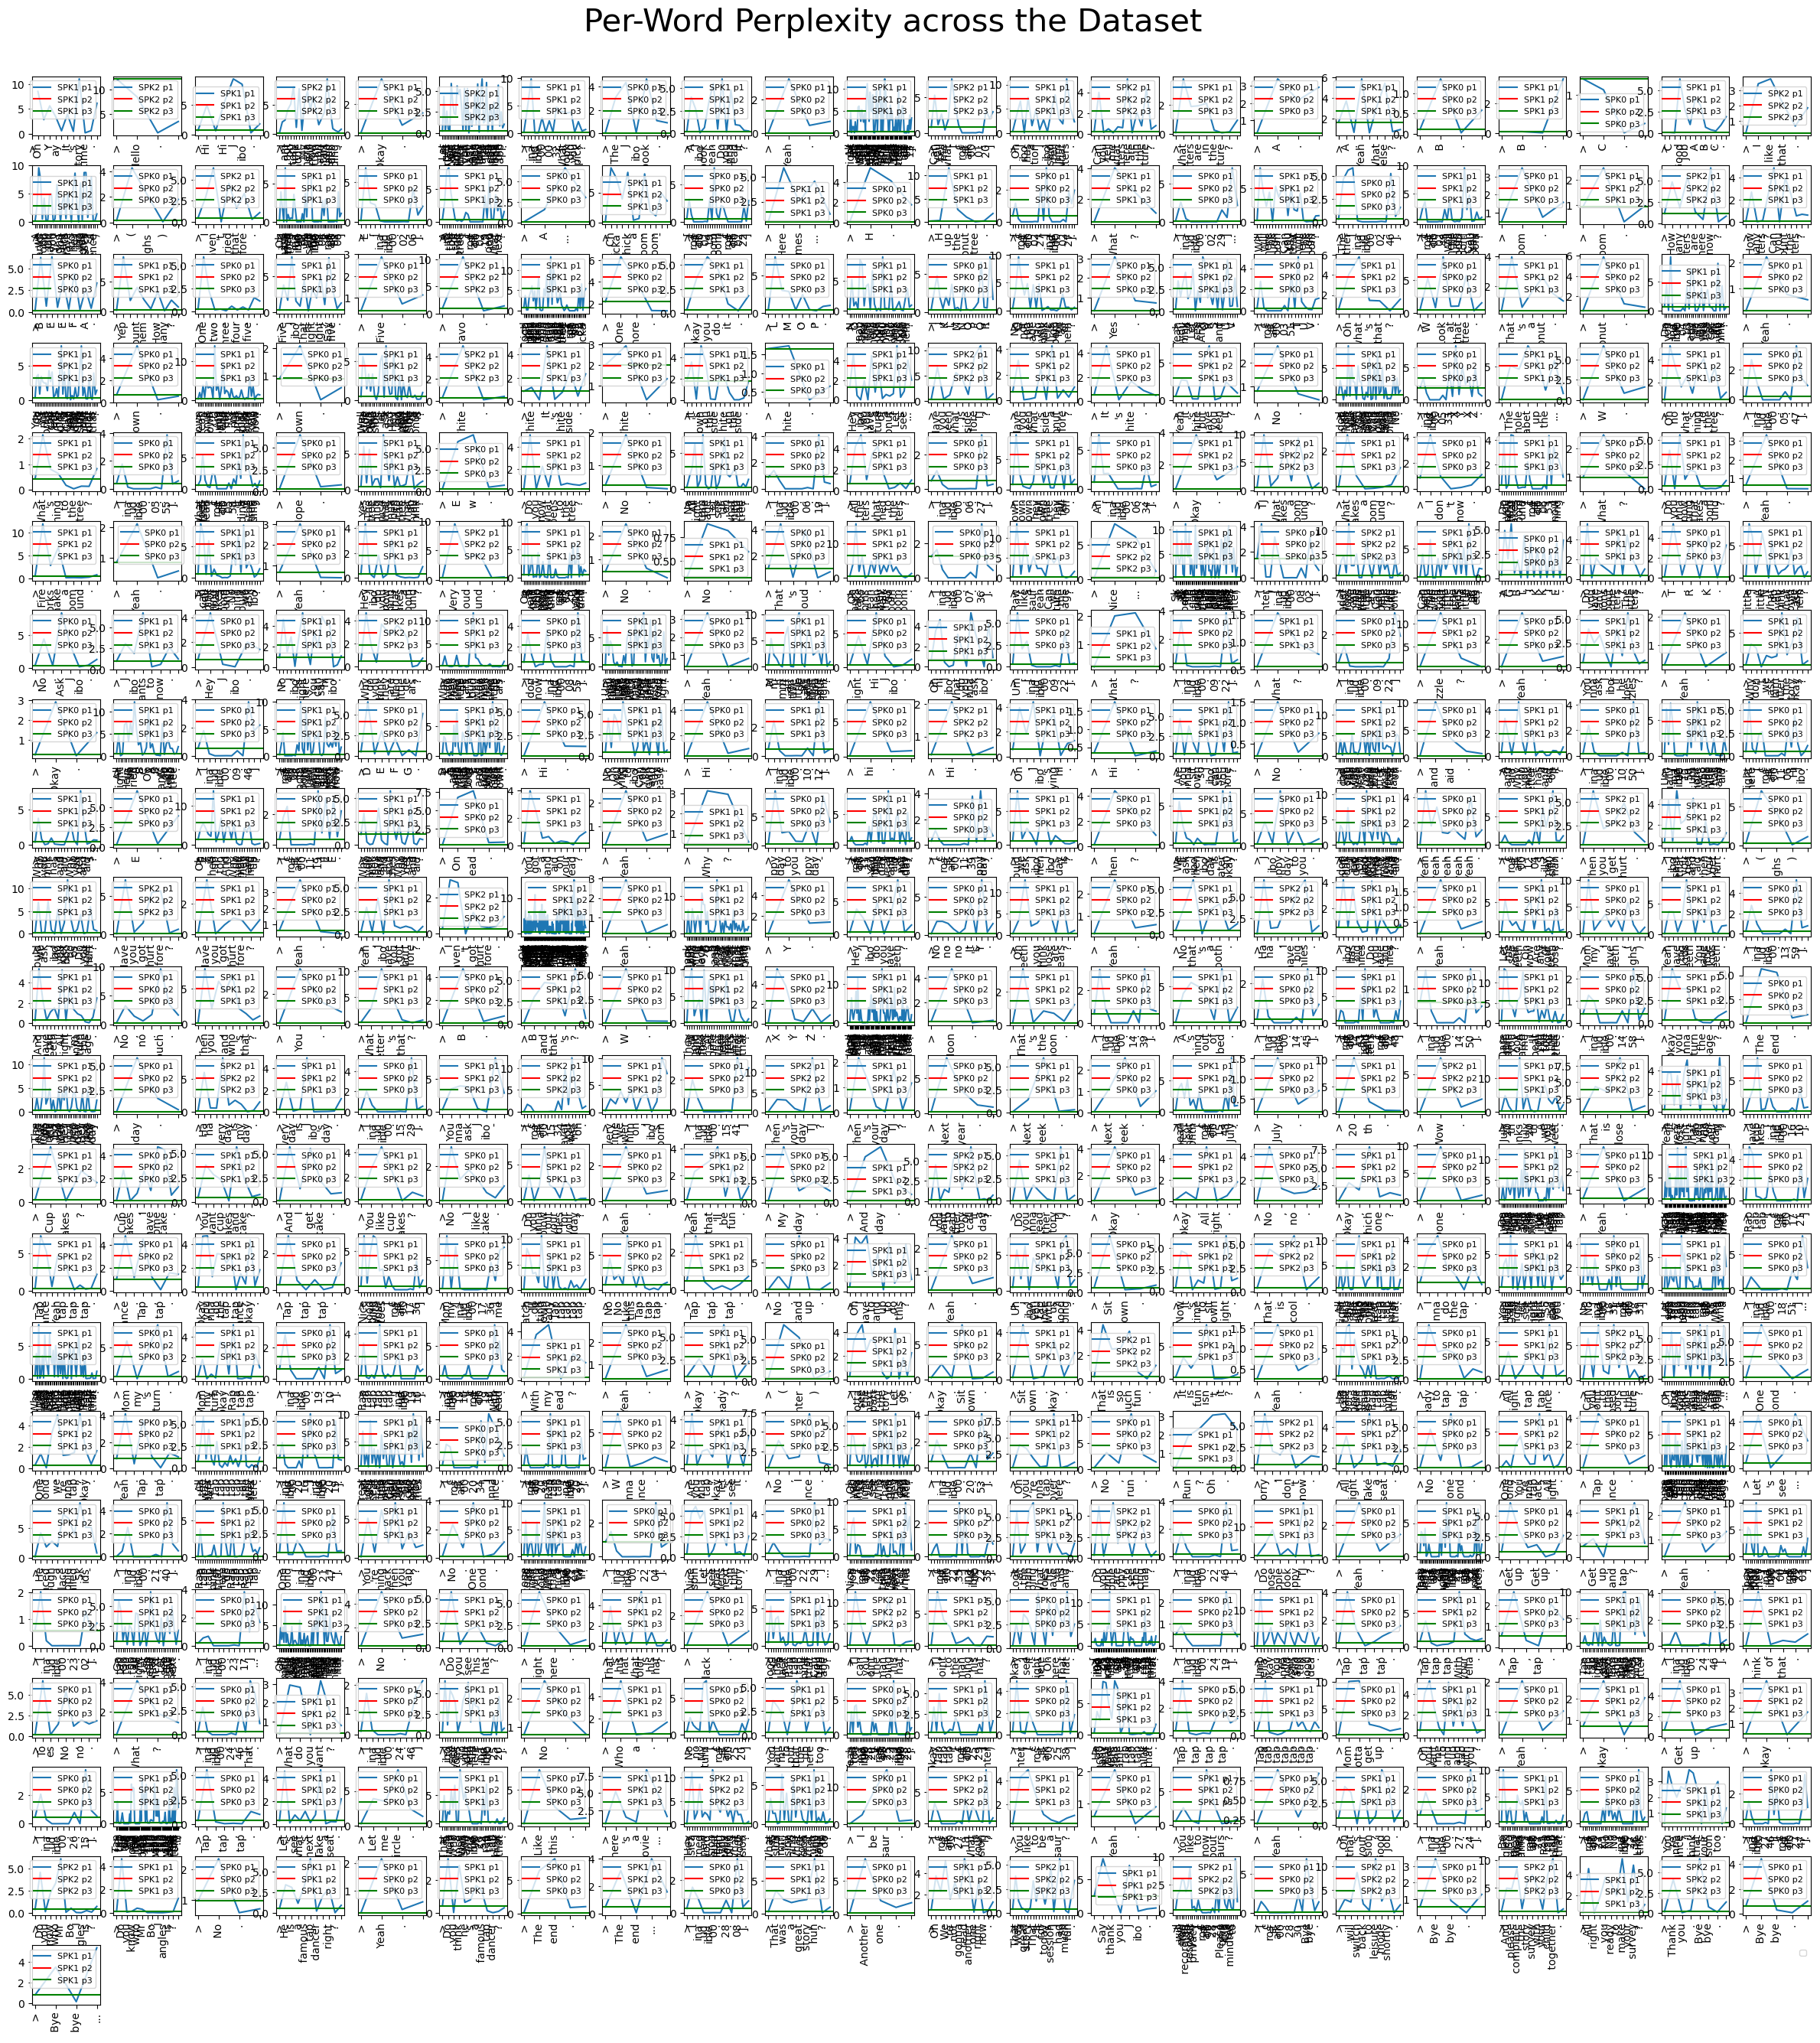


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x7fe638d0fc40> (for post_execute):



KeyboardInterrupt



Error in callback <function flush_figures at 0x7fe5c9880f40> (for post_execute):



KeyboardInterrupt



In [60]:
dominance = {}
for content, name in zip(tri_pilot_df["file_content"], tri_pilot_df["file_name"]):
    dominance[name] = {}
    pattern = '<(SPK[0-9]|MOD)>'
    matches = re.findall(pattern, "".join(content))
    content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
    content = [re.sub(pattern,">", d) for d in content]
    assert len(perplexity_scores_p1[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)
    tokens = [tokenizer(token, return_tensors="pt", return_offsets_mapping=True).input_ids[0] for token in content]
    assert len(torch.cat(tokens)) == len(perplexity_scores_p1[name])
    compute_graph_perplexity(tokens, perplexity_scores_p1[name],[np.nan for _ in range(len(perplexity_scores_p1[name]))],matches, pattern=pattern) 

In [13]:
import difflib

def visualize_string_diff(str1, str2):
    # Create a Differ object
    differ = difflib.Differ()
    
    # Compute the difference between the two strings
    diff = differ.compare(str1.splitlines(), str2.splitlines())
    
    # Join the differences with newline for visualization
    diff_str = '\n'.join(diff)
    
    return diff_str

In [14]:
import glob

name="p08_s03"
content = tri_pilot_df[tri_pilot_df["file_name"] == name]["file_content"][0]
pattern = '<(SPK[0-9]|MOD)>'
matches = re.findall(pattern, "".join(content))
content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
content = [re.sub(pattern,">", d) for d in content]
assert len(perplexity_scores_p3[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)

In [15]:
from transformers import GPT2Tokenizer

# Initialize the GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
bin_width = 5


def compute_bins(content, t_u):
    
    len_per_token = [len(tokenizer(dialogue, return_tensors="pt").input_ids[0].detach().numpy()) for dialogue in content]
    tokens = [tokenizer(dialogue, return_tensors="pt").input_ids[0].detach().numpy() for dialogue in content]
    time_per_token = []
  
    for idx in range(len(content)):   
        if len(tokens[idx]) == 0:
            time_per_token.append(0)
        else:
            time_per_token.append(t_u[idx] / len(tokens[idx]))

    all_tokens = []
    for dialogue in content:
        all_tokens += list(tokenizer(dialogue, return_tensors="pt").input_ids[0].detach().numpy())

    all_tokens = np.asarray(all_tokens)
    assert len(all_tokens) == np.asarray(len_per_token).sum()
    assert len(len_per_token) == len(time_per_token)

    elements = [(count, value) for count, value in zip(len_per_token, time_per_token)]
    arr = sum([[val] * num for num, val in elements], [])
    data = np.asarray(arr).cumsum()

    bin_edges = np.arange(0, np.ceil(data.max()) + bin_width, bin_width)

    idx_bin = np.digitize(data, bin_edges)
    unique_bins = np.unique(idx_bin)
    assert len(all_tokens) == len(idx_bin)
    return idx_bin

In [16]:
from transformers import GPT2Tokenizer

# Initialize the GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
bin_width = 5

In [17]:
def create_mask(arr):
    transformed_arr = []
    for num in arr:
        if num == 0:
            transformed_arr.append(0)
        else:
            transformed_arr.extend([1] * num)
    return np.asarray(transformed_arr, dtype=np.int64).cumsum() - 1

def compute_per_utterance_mean_perplexity(dialog, tokens, perpl, matches, pattern = '<(SPK[1-9]|MOD)>'):
    
    masked_speakers = []
    encodings = torch.cat(tokens)    
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)
    
    warnings.filterwarnings("ignore", message="Mean of empty slice")

    pos_nxt_speaker_token = np.asarray([0] + [len(tokenizer(d, return_tensors="pt").input_ids[0]) for d in dialog])
    pos_nxt_speaker_token_cumsum = pos_nxt_speaker_token.cumsum()
    bin_edges = np.concatenate([[0], tokens_ids_per_sentence])
    idx_bin = np.digitize(pos_nxt_speaker_token_cumsum, bin_edges) - 1

    assert len(idx_bin) - 1 == len(dialog)
    assert len(pos_nxt_speaker_token_cumsum) - 1 == len(dialog)

    prev_idx_pp = 0
    utterance_to_ppl = []
    current_sum = 0
    nxs_spk = []
    substring_ppl_ls = []
    utterance_to_ppl_sent = []
    
    for idx in range(len(tokens)):
        idxs_nxt_speaker_token = pos_nxt_speaker_token_cumsum[np.argwhere(np.isin(idx_bin, idx)).flatten()] - prev_idx_pp
        idx_pp = tokens_ids_per_sentence[idx]
        encodings_ = encodings[prev_idx_pp:idx_pp]
        perpl_per_sent = perpl[prev_idx_pp:idx_pp]
        substring_ppl = [np.nanmean(perpl_per_sent[start:end]) for start, end in zip([0] + list(idxs_nxt_speaker_token), list(idxs_nxt_speaker_token) + [None])]
        substrings_detoken = [encodings_[start:end] for start, end in zip([0] + list(idxs_nxt_speaker_token), list(idxs_nxt_speaker_token) + [None])] 
        substring_ppl_ls = [substring_ppl[num] for num, s in enumerate(substrings_detoken) if s.numel() != 0]
        utterance_to_ppl.append(substring_ppl_ls)     
        utterance_to_ppl_sent.append([tokenizer.decode(token, skip_special_tokens=True) for token in substrings_detoken])
        prev_idx_pp = idx_pp
        
        if len(idxs_nxt_speaker_token)>0 and len(substring_ppl_ls) != len(idxs_nxt_speaker_token):
            nxs_spk.append(0)
        nxs_spk.append(len(idxs_nxt_speaker_token))

    return  utterance_to_ppl, utterance_to_ppl_sent, create_mask(nxs_spk)

In [35]:
from datetime import datetime

# Sample timestamp
def to_sec_elapsed(timestamp_str):
    timestamp_dt = datetime.strptime(timestamp_str, "%H:%M:%S")
    total_seconds = timestamp_dt.hour * 3600 + timestamp_dt.minute * 60 + timestamp_dt.second
    return total_seconds


In [38]:
import glob 

def compute_dominance_ppl(perplexity_scores):
    directory = "/u/sebono/conversational_dominance/data/external/triadic-pilot/"
    
    dominance_p = {}
    dominance_p_decoded_sent = {}
    
    for content, name in zip(tri_pilot_df["file_content"], tri_pilot_df["file_name"]):
        if name not in perplexity_scores:
            continue
        dominance_p[name] = {}
        dominance_p_decoded_sent[name] = {}
        print(f"trying {name}")
        filepath = glob.os.path.join(directory, name) + "_REV.csv"
        d = pd.read_csv(filepath)
        times = [to_sec_elapsed(t) for t in d["timestamp"]]
        d_to_t = [times[i] - times[i-1] for i in range(1, len(times))]+[np.asarray(times)[-1] - np.asarray(times)[-2]]
        pattern = '<(SPK[0-9]|MOD)>'
        matches = np.asarray(re.findall(pattern, "".join(content)))
        content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
        content = [re.sub(pattern,">", d) for d in content]
        assert len(content) == len(matches)
        try:
            assert len(content) == len(d_to_t)
        except:
            continue
        assert len(matches) == len(content)
        idx_bin = compute_bins(content, d_to_t)
        assert len(perplexity_scores[name]) == tokenizer(" ".join(content), return_tensors="pt").input_ids.size(1)
        assert len(idx_bin) == tokenizer(" ".join(content), return_tensors="pt").input_ids.size(1)
        unique_bins = np.unique(idx_bin)
        encodings = tokenizer(" ".join(content), return_tensors="pt").input_ids.ravel()
        tokens = [tokenizer(token, return_tensors="pt").input_ids[0] for token in content]
        result_list = []
        for i in range(1, unique_bins[-1]+1):
            if i in unique_bins:
                result_list += torch.tensor([encodings[idx_bin == i].tolist()])
            else:
                result_list += torch.tensor([])
        len_tokens = np.asarray([len(d) for d in tokens]).cumsum()
        result, result_decoded_sent, nxs_spk = compute_per_utterance_mean_perplexity(content,result_list,perplexity_scores[name], matches)

        idx=0
        for t, (elms,elms_decoded_sent) in enumerate(zip(result,result_decoded_sent)):
            dominance_p[name][t] = {}
            dominance_p_decoded_sent[name][t] = {}
            for c, (a,b) in zip(elms_decoded_sent, zip(matches[nxs_spk][idx:idx + len(elms)],elms)):
                if a not in dominance_p[name][t]:
                    dominance_p[name][t][a] = []
                    dominance_p_decoded_sent[name][t][a] = []
                dominance_p[name][t][a].append(b)
                dominance_p_decoded_sent[name][t][a].append(c)

            for k in dominance_p[name][t].keys():
                dominance_p[name][t][k] = np.mean(dominance_p[name][t][k])
            idx+=len(elms)
            
    return dominance_p,dominance_p_decoded_sent

In [39]:
dominance_p1,dominance_p_decoded_sent_p1 = compute_dominance_ppl(perplexity_scores_p1)
dominance_p3,dominance_p_decoded_sent_p3 = compute_dominance_ppl(perplexity_scores_p3)

trying p08_s03
trying p10_s02
trying p09_s04
trying p09_s05
trying p12_s02
trying p05_s04
trying p02_s00
trying p07_s01
trying p04_s01
trying p01_s02
trying p01_s00
trying p10_s04
trying p06_s00
trying p09_s01
trying p02_s01
trying p12_s04
trying p03_s02
trying p06_s01
trying p09_s02
trying p07_s02
trying p07_s00
trying p01_s05
trying p02_s02
trying p06_s02
trying p08_s00
trying p02_s04
trying p05_s01
trying p10_s05
trying p06_s04
trying p10_s03
trying p03_s01
trying p12_s05
trying p08_s02
trying p09_s00
trying p11_s02
trying p05_s03
trying p09_s03
trying p02_s03
trying p11_s03
trying p04_s05
trying p05_s05
trying p01_s03
trying p12_s01
trying p05_s00
trying p12_s03
trying p02_s05
trying p11_s04
trying p04_s00
trying p07_s03
trying p08_s03
trying p10_s02
trying p09_s04
trying p09_s05
trying p12_s02
trying p05_s04
trying p02_s00
trying p07_s01
trying p04_s01
trying p01_s02
trying p01_s00
trying p10_s04
trying p06_s00
trying p09_s01
trying p02_s01
trying p12_s04
trying p03_s02
trying p06

In [42]:
path = "/u/sebono/conversational_dominance/data/processed/triadic-pilot/"
with open(f'{path}/dominance_p1.pkl', 'wb') as f:
    pickle.dump(dominance_p1, f)
with open(f'{path}/dominance_p3.pkl', 'wb') as f:
    pickle.dump(dominance_p3, f)

### Starting Analysis

In [43]:
import pickle
path = "/u/sebono/conversational_dominance/data/processed/triadic-pilot/"
with open(f'{path}/dominance_p1.pkl', 'rb') as f:
    dominance_p1 = pickle.load(f)
with open(f'{path}/dominance_p3.pkl', 'rb') as f:
    dominance_p3 = pickle.load(f)

In [44]:
len(list(dominance_p3.keys())), len(list(dominance_p1.keys()))

(49, 49)

In [72]:
def speaker_ids(names):
    d_names = []
    re_names = []
    for id, re_n in enumerate(names):
        n = f"SPK{id}"
        re_names.append(re_n)
        d_names.append(n)
    return dict(zip(re_names,d_names))

import os
import pandas as pd
import numpy as np
import re
# List to hold the dataframes
dialogues = []
dialogues_ids = []
timestamps=[]
d_to_t = []
t_to_d = []
users = []
maps = {}
directory = "/u/sebono/conversational_dominance/data/external/triadic-pilot/"
# Iterate over all CSV files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        d = pd.read_csv(filepath)
        utterances = d["content"]
        speakers = np.unique(np.asarray(d["speaker"]))
        map_names = speaker_ids(speakers)
        dialogues_ids.append(filename.replace(".csv",""))
        maps[filename.replace("_REV.csv","")] = map_names

In [77]:
def ppl_lists(dominance_p1):
    child = maps[key]["Child"]
    parent = maps[key]["Parent"]

    child_list = []
    parent_list = []

    for t in dominance_p1.keys():
        if child in dominance_p1[t]:
            child_list.append(dominance_p1[t][child])
        else:
            child_list.append(np.nan)
        if parent in dominance_p1[t]:
            parent_list.append(dominance_p1[t][parent])
        else:
            parent_list.append(np.nan)
    return parent_list, child_list 

In [92]:
maps

{'p08_s03': {'Child': 'SPK0', 'Parent': 'SPK1', 'Robot': 'SPK2'},
 'p10_s02': {'Child': 'SPK0',
  'Others': 'SPK1',
  'Parent': 'SPK2',
  'Robot': 'SPK3'},
 'p09_s04': {'Child': 'SPK0', 'Parent': 'SPK1', 'Robot': 'SPK2'},
 'p09_s05': {'Child': 'SPK0',
  'Others': 'SPK1',
  'Parent': 'SPK2',
  'Robot': 'SPK3'},
 'p12_s02': {'Child': 'SPK0', 'Parent': 'SPK1', 'Robot': 'SPK2'},
 'p05_s04': {'3rd person': 'SPK0',
  'Child': 'SPK1',
  'Parent': 'SPK2',
  'Robot': 'SPK3'},
 'p02_s00': {'Child': 'SPK0',
  'Parent': 'SPK1',
  'Robot': 'SPK2',
  'Speaker 2': 'SPK3',
  'Speaker 5': 'SPK4'},
 'p07_s01': {'Child': 'SPK0', 'Parent': 'SPK1', 'Robot': 'SPK2'},
 'p04_s01': {'Child': 'SPK0', 'Parent': 'SPK1', 'Robot': 'SPK2'},
 'p01_s02': {'Child': 'SPK0', 'Parent': 'SPK1', 'Robot': 'SPK2'},
 'p01_s00': {'3rd Person': 'SPK0',
  'Child': 'SPK1',
  'Parent': 'SPK2',
  'Robot': 'SPK3'},
 'p10_s04': {'Child': 'SPK0', 'Parent': 'SPK1', 'Robot': 'SPK2'},
 'p06_s00': {'Child': 'SPK0', 'Parent': 'SPK1', 'Robot

In [97]:
import os
import glob
import pandas as pd
import numpy as np

path_annotations = "/u/sebono/conversational_dominance/data/processed/triadic-pilot/annotation_files/child-arousal/aggregated_annotation_files.csv"
annotation_list = pd.read_csv(path_annotations)
session_ids = np.unique(annotation_list['session_id'])
final_df = pd.DataFrame([])
annotations = []

for key in dominance_p1.keys():
    print(key + "_zoom_trimmed.txt")
    averages = annotation_list[annotation_list["session_id"] == key + "_zoom_trimmed.txt"][["avg_rating", "std_rating"]].to_numpy()[:len(dominance_p3[key])]
    if annotations is None:
        continue
    try:
        assert pd.DataFrame(averages).shape[0] == len(dominance_p3[key])
        assert len(dominance_p3[key]) == len(dominance_p1[key])
    except:
        print(key)
        print(pd.DataFrame(averages).shape[0], len(dominance_p3[key]))
        continue
    try:
        parent_list_p1, child_list_p1 = ppl_lists(dominance_p1[key])
        parent_list_p3, child_list_p3 = ppl_lists(dominance_p3[key])
        df = pd.DataFrame({"child_p1":child_list_p1,"child_p3":child_list_p3, "CHILD's arousal std": averages[:,0], "CHILD's arousal mean": averages[:,1]})
        final_df = pd.concat([final_df, df], axis=0)
    except:
        pass

p08_s03_zoom_trimmed.txt
p10_s02_zoom_trimmed.txt
p09_s04_zoom_trimmed.txt
p09_s05_zoom_trimmed.txt
p12_s02_zoom_trimmed.txt
p05_s04_zoom_trimmed.txt
p02_s00_zoom_trimmed.txt
p02_s00
148 158
p07_s01_zoom_trimmed.txt
p04_s01_zoom_trimmed.txt
p01_s02_zoom_trimmed.txt
p01_s00_zoom_trimmed.txt
p10_s04_zoom_trimmed.txt
p06_s00_zoom_trimmed.txt
p09_s01_zoom_trimmed.txt
p02_s01_zoom_trimmed.txt
p12_s04_zoom_trimmed.txt
p03_s02_zoom_trimmed.txt
p06_s01_zoom_trimmed.txt
p09_s02_zoom_trimmed.txt
p07_s02_zoom_trimmed.txt
p07_s00_zoom_trimmed.txt
p01_s05_zoom_trimmed.txt
p02_s02_zoom_trimmed.txt
p06_s02_zoom_trimmed.txt
p08_s00_zoom_trimmed.txt
p02_s04_zoom_trimmed.txt
p05_s01_zoom_trimmed.txt
p10_s05_zoom_trimmed.txt
p10_s05
259 260
p06_s04_zoom_trimmed.txt
p10_s03_zoom_trimmed.txt
p03_s01_zoom_trimmed.txt
p12_s05_zoom_trimmed.txt
p08_s02_zoom_trimmed.txt
p09_s00_zoom_trimmed.txt
p11_s02_zoom_trimmed.txt
p05_s03_zoom_trimmed.txt
p09_s03_zoom_trimmed.txt
p02_s03_zoom_trimmed.txt
p11_s03_zoom_trimm

In [95]:
final_df

,child_p1,child_p3,CHILD's arousal std,CHILD's arousal mean
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
351,NaN,NaN,0.0,0.0
352,1.669617,0.021332,NaN,NaN
353,NaN,NaN,NaN,NaN
354,NaN,NaN,NaN,NaN


## Looking at correlations

In [98]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import plotly
import plotly.io as pio
pio.renderers.default = 'iframe'
import plotly.express as px
plotly.offline.init_notebook_mode(connected=True)
import seaborn as sns

In [99]:
cmp = 'algae'
def correlation_heatmap(y_cols, x_cols, full_data):
    '''
    Uses scipy.stats.spearmanr function
    Params:
    y_cols, x_cols: sets of column titles (strings)
    full_data: pandas dataframe that includes all columns listed in y_cols, x_cols
    Returns:
    corr: Spearman correlation coefficient matrix (y_cols = rows, x_cols = cols of matrix)
    fig_corr: annotated plotly heatmap of coefficients
    p: Spearman p-value matrix
    fig_p: annotated plotly heatmap of p-values
    '''
    cols = y_cols+x_cols
    all_correlations = scipy.stats.spearmanr(full_data[cols], nan_policy='omit')
    corr = all_correlations.statistic[:len(y_cols), -len(x_cols):]
    corr = pd.DataFrame(corr)
    corr.columns = x_cols
    corr.index = y_cols

    p = all_correlations.pvalue[:len(y_cols), -len(x_cols):]
    p = pd.DataFrame(p)
    p.columns = x_cols
    p.index = y_cols
    
    fig_corr = px.imshow(corr, text_auto=True, aspect='auto', color_continuous_scale='agsunset')
    fig_r2 = px.imshow(corr**2, text_auto=True, aspect='auto', color_continuous_scale='agsunset')
    fig_p = px.imshow(p, text_auto=True, aspect='auto', color_continuous_scale='gray_r')

    return corr, fig_corr, p, fig_p, fig_r2

In [100]:
def correlation(df_final):
    corr, fig_corr, p, fig_p, fig_r2 = correlation_heatmap(col_1, col_2, df_final)
    fig_corr.show()
    fig_p.show()
    fig_r2.show()
    return corr, fig_corr, p, fig_p, fig_r2

In [101]:
affective_states = ["CHILD's arousal std","CHILD's arousal mean"]
cognitive_states = ["child_p1", "child_p3"]

In [102]:
col_1 = affective_states[:2]
col_2 = cognitive_states[:2]
corr, fig_corr, p, fig_p, fig_r2 = correlation(final_df)

In [103]:
col_1 = affective_states[2:]
col_2 = cognitive_states[2:]
corr, fig_corr, p, fig_p, fig_r2 = correlation(final_df)

IndexError: index 0 is out of bounds for axis 1 with size 0

In [104]:
col_1 = affective_states
col_2 = cognitive_states
corr, fig_corr, p, fig_p, fig_r2 = correlation(final_df)

### Plot Values